In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import re
import random

/home/ziyi/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# Network Parameters
num_input = 1
timesteps = 80 # timesteps
num_hidden = 100 # hidden layer num of features
num_output= 1

In [3]:
def read_sensor(filename):
#     print(filename)
    f_sensor=open(filename)  
    dataset=pd.read_csv(f_sensor)
    
    data_x = np.array(dataset.iloc[:, 1:2])
#     print(data_x.shape)
    return data_x


def read_xml(filename, length):
    f = open(filename)
    cts = f.read()
    f.close()

    p_foot = re.compile(r'<WhichFoot>(.*?)</WhichFoot>')
    all_foot = p_foot.findall(cts)

    p_time = re.compile(r'<Time>(.*?)</Time>')
    all_time = p_time.findall(cts)

    strike_times = []
    #L-1 R-0
    cur_dir = 1
    if(all_foot[0] == 'L'):
        cur_dir = 0
    strike_times.append([0.0, cur_dir])
    for i in range(len(all_foot)):
        if(all_foot[i]=='L'):
            strike_times.append([float(all_time[i]), 1])
        else:
            strike_times.append([float(all_time[i]), 0])
    strike_times.append([length/25.0, 0.5])
#     print(strike_times[0:10])
#     print(len(strike_times))

    window_y = []
    strike_index=0
    for i in range(length):
        if(i/25.0 >= strike_times[strike_index+1][0]):
            strike_index += 1
        window_y.append([strike_times[strike_index][1]])
         
    return window_y

In [6]:
data_x = []
window_y = []
for i in range(1,5):
    data_x_part = read_sensor('weallwalk/Azimuth/T'+str(i)+'_ID1_GD-i61L.csv')
    window_y_part = read_xml('weallwalk/xml/T'+str(i)+'_ID1_GD.xml', len(data_x_part))
    
    for i in range(len(data_x_part)-timesteps):
        x=data_x_part[i:i+timesteps]
        y=window_y_part[i+timesteps]
        data_x.append(x)
        window_y.append(y)
        
for i in range(1,5):
    data_x_part = read_sensor('weallwalk/Azimuth/T'+str(i)+'_ID1_GD-i62R.csv')
    window_y_part = read_xml('weallwalk/xml/T'+str(i)+'_ID1_GD.xml', len(data_x_part))
    
    for i in range(len(data_x_part)-timesteps):
        x=data_x_part[i:i+timesteps]
        y=window_y_part[i+timesteps]
        data_x.append(x)
        window_y.append(y)
        
print(len(data_x)) #21843
print(len(window_y))

28492
28492


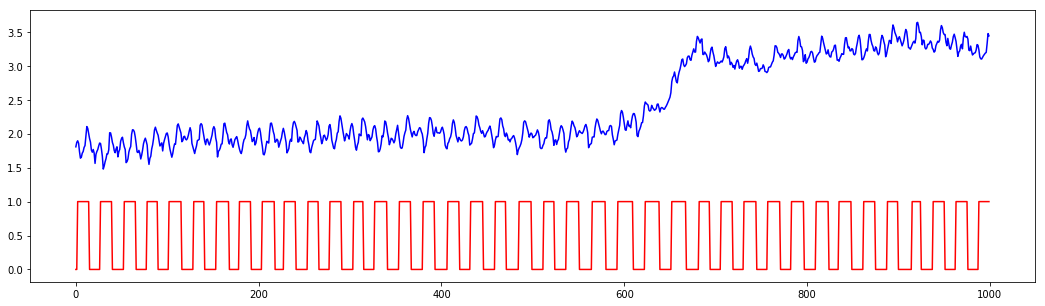

In [10]:
plt.figure(figsize=(18, 5))
start=20000
end=21000
#time back to 0
plt.plot([i[0] for i in data_x[start:end]], 'b')
plt.plot([i[0] for i in window_y[start:end]], 'r')
plt.show()

In [11]:
order = list(range(0,len(data_x),1))
random.shuffle(order)

train_x = [data_x[i] for i in order]
train_y = [window_y[i] for i in order]

print(len(train_x))

28492


In [12]:
test_x, test_y=[], []
for i in range(5,7):
    data_x_part = read_sensor('weallwalk/Azimuth/T'+str(i)+'_ID1_GD-i61L.csv')
    window_y_part = read_xml('weallwalk/xml/T'+str(i)+'_ID1_GD.xml', len(data_x_part))
    
    for i in range(len(data_x_part)-timesteps):
        x=data_x_part[i:i+timesteps]
        y=window_y_part[i+timesteps]
        test_x.append(x)
        test_y.append(y)
        
for i in range(5,7):
    data_x_part = read_sensor('weallwalk/Azimuth/T'+str(i)+'_ID1_GD-i62R.csv')
    window_y_part = read_xml('weallwalk/xml/T'+str(i)+'_ID1_GD.xml', len(data_x_part))
    
    for i in range(len(data_x_part)-timesteps):
        x=data_x_part[i:i+timesteps]
        y=window_y_part[i+timesteps]
        test_x.append(x)
        test_y.append(y)

print(len(test_x))

14233


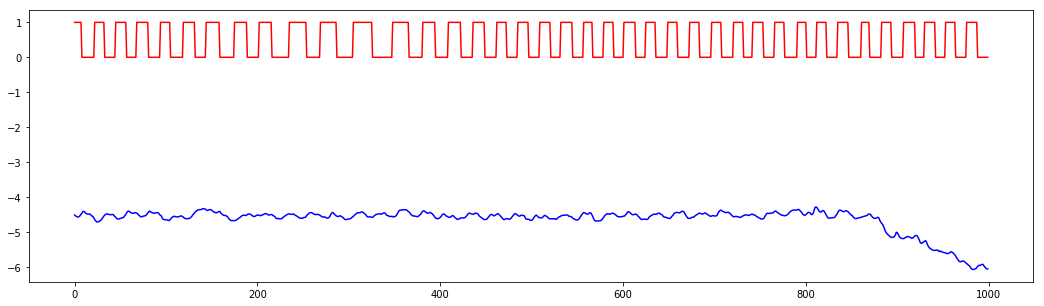

In [16]:
start=10000
end=11000
plt.figure(figsize=(18, 5))
plt.plot([i[0] for i in data_x[start:end]], 'b')
plt.plot([i[0] for i in test_y[start:end]], 'r')
plt.show()

In [17]:
NUM_LAYERS=2

def LstmCell():
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_hidden, state_is_tuple=True)
    return lstm_cell

graph = tf.Graph()
with graph.as_default(), tf.device('/gpu:0'):
    # tf Graph input
    X = tf.placeholder("float", [None, timesteps, num_input])
    Y = tf.placeholder("float", [None, num_output])
    
    # Define weights
    weights = {
        'out': tf.Variable(tf.random_normal([num_hidden, num_output]))
    }
    biases = {
        'out': tf.Variable(tf.random_normal([num_output]))
        #'out':tf.Variable(tf.zeros([1]))
    }
    
    def RNN(x, weights, biases):
        x = tf.unstack(x, timesteps, 1)
        cell = tf.contrib.rnn.MultiRNNCell([LstmCell() for _ in range(NUM_LAYERS)])
        outputs, state = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
        outputs = tf.transpose(outputs, [1,0,2])

        return tf.matmul(outputs[-1], weights['out']) + biases['out']
    

    logits = RNN(X, weights, biases)
    mean_train = tf.reduce_mean(X)
    loss = tf.reduce_mean(tf.squared_difference(logits, Y))
    #loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))

    optimizer = tf.train.AdamOptimizer(learning_rate = 0.001).minimize(loss)
    
    saver = tf.train.Saver()

In [18]:
batch_size = 256
batch_start = 0;
train_length = len(train_x)
train_x.extend(train_x[0:batch_size])
train_y.extend(train_y[0:batch_size])
training_steps = 6001

In [19]:
config = tf.ConfigProto(allow_soft_placement=True)
with tf.Session(graph=graph, config=config) as session:
#     saver.restore(session, tf.train.latest_checkpoint('lstm_check'))
#     saver.restore(session, "lstm_check/my-model-gpu-batch-test-add-data.ckpt-10000")
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(training_steps):      
        feed_dict = {X: train_x[batch_start:batch_start+batch_size], Y: train_y[batch_start:batch_start+batch_size]}
        batch_start += batch_size
        if(batch_start>=train_length):
            batch_start -=train_length
        _, l, predictions, m = session.run([optimizer, loss, logits,mean_train], feed_dict = feed_dict)
        if (step % 200 == 0):
            print('Loss at step %d: %f' % (step, l))
        if (step % 2000 == 0):
            saver.save(session, 'lstm_check/my-model-gpu-azimuth.ckpt', global_step=step)
    test_loss, test_logits = session.run([loss,logits], feed_dict={X: test_x, Y: test_y})

Initialized


InternalError: Blas GEMM launch failed : a.shape=(256, 101), b.shape=(101, 400), m=256, n=400, k=101
	 [[Node: rnn/while/rnn/multi_rnn_cell/cell_0/cell_0/basic_lstm_cell/MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](rnn/while/rnn/multi_rnn_cell/cell_0/cell_0/basic_lstm_cell/concat, rnn/while/rnn/multi_rnn_cell/cell_0/cell_0/basic_lstm_cell/MatMul/Enter)]]
	 [[Node: add/_15 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_1222_add", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'rnn/while/rnn/multi_rnn_cell/cell_0/cell_0/basic_lstm_cell/MatMul', defined at:
  File "/home/ziyi/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/ziyi/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/ziyi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/ziyi/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/ziyi/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/ziyi/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/ziyi/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/ziyi/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ziyi/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/ziyi/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/ziyi/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/ziyi/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ziyi/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/ziyi/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/ziyi/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/ziyi/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/ziyi/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/ziyi/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/ziyi/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/ziyi/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-17-2c263a94bf6e>", line 31, in <module>
    logits = RNN(X, weights, biases)
  File "<ipython-input-17-2c263a94bf6e>", line 25, in RNN
    outputs, state = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
  File "/home/ziyi/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/rnn.py", line 614, in dynamic_rnn
    dtype=dtype)
  File "/home/ziyi/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/rnn.py", line 777, in _dynamic_rnn_loop
    swap_memory=swap_memory)
  File "/home/ziyi/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2816, in while_loop
    result = loop_context.BuildLoop(cond, body, loop_vars, shape_invariants)
  File "/home/ziyi/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2640, in BuildLoop
    pred, body, original_loop_vars, loop_vars, shape_invariants)
  File "/home/ziyi/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2590, in _BuildLoop
    body_result = body(*packed_vars_for_body)
  File "/home/ziyi/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/rnn.py", line 762, in _time_step
    (output, new_state) = call_cell()
  File "/home/ziyi/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/rnn.py", line 748, in <lambda>
    call_cell = lambda: cell(input_t, state)
  File "/home/ziyi/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/rnn_cell_impl.py", line 183, in __call__
    return super(RNNCell, self).__call__(inputs, state)
  File "/home/ziyi/anaconda3/lib/python3.6/site-packages/tensorflow/python/layers/base.py", line 575, in __call__
    outputs = self.call(inputs, *args, **kwargs)
  File "/home/ziyi/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/rnn_cell_impl.py", line 1066, in call
    cur_inp, new_state = cell(cur_inp, cur_state)
  File "/home/ziyi/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/rnn_cell_impl.py", line 183, in __call__
    return super(RNNCell, self).__call__(inputs, state)
  File "/home/ziyi/anaconda3/lib/python3.6/site-packages/tensorflow/python/layers/base.py", line 575, in __call__
    outputs = self.call(inputs, *args, **kwargs)
  File "/home/ziyi/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/rnn_cell_impl.py", line 441, in call
    value=self._linear([inputs, h]), num_or_size_splits=4, axis=1)
  File "/home/ziyi/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/rnn_cell_impl.py", line 1189, in __call__
    res = math_ops.matmul(array_ops.concat(args, 1), self._weights)
  File "/home/ziyi/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py", line 1891, in matmul
    a, b, transpose_a=transpose_a, transpose_b=transpose_b, name=name)
  File "/home/ziyi/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_math_ops.py", line 2437, in _mat_mul
    name=name)
  File "/home/ziyi/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/ziyi/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/home/ziyi/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InternalError (see above for traceback): Blas GEMM launch failed : a.shape=(256, 101), b.shape=(101, 400), m=256, n=400, k=101
	 [[Node: rnn/while/rnn/multi_rnn_cell/cell_0/cell_0/basic_lstm_cell/MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](rnn/while/rnn/multi_rnn_cell/cell_0/cell_0/basic_lstm_cell/concat, rnn/while/rnn/multi_rnn_cell/cell_0/cell_0/basic_lstm_cell/MatMul/Enter)]]
	 [[Node: add/_15 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_1222_add", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
